Initialisation

In [6]:
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from math import log

N = 10 #Number of points

Dataset generation

In [7]:
def point_generation():
    """
    Return a list of two numbers in [0,1]
    """
    return rd.rand(2)

In [8]:
def generateB(n):
    """
    Return list of n list of 2 elements
    """
    return rd.uniform(size=(n, 2))

In [9]:
def generateA(n):

    A=generateB(n-4)

    #adding the corner
    A= np.append(A,[[0,0]],axis=0)
    A= np.append(A,[[0,1]],axis=0)
    A= np.append(A,[[1,0]],axis=0)
    A= np.append(A,[[1,1]],axis=0)

    #rotating the set
    angle = rd.uniform() * 2 * np.pi
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    A = A @ rotation_matrix

    # Shuffle the points
    np.random.shuffle(A)
    return A


In [10]:
def generateC(n,r):
    C=[]
    for i in range(n):
        ri=rd.uniform()*r
        ai = rd.uniform()*2*np.pi
        C.append( np.array([ri*np.cos(ai),ri*np.sin(ai)]))
    return np.array(C)

In [11]:
def generateD(n,r):
    D=[]
    for i in range(n):
        angle = rd.uniform()*2*np.pi
        D.append( np.array([r*np.cos(angle),r*np.sin(angle)]))
    return np.array(D)


Sweeping

In [12]:
def clockwise(a,b,c):
    #Takes 3 points a,b,c of type np.array and return if the triangle ABC is clock-wised 
    
    if np.linalg.det(np.concatenate(((c-b).reshape(2,1),(b-a).reshape(2,1)),axis=1))>0: return True
    else: return False

In [13]:
def sweeping_algo(l):
    #l is a list of points of type np.array, assuming there are >= 2 points and sorted by increasing x
    order=l[:, 0].argsort()
    l=l[order]
    N=l.shape[0]

    hull=[]

    hull.append(l[0])
    hull.append(l[1])

    for i in (range(2,N)):
        if clockwise(hull[-2],hull[-1],l[i]): hull.append(l[i])
        else : 
            while len(hull)>=2 and not clockwise(hull[-2],hull[-1],l[i]): 
                hull.pop()
            hull.append(l[i])

    hull2=[]
    hull2.append(l[N-1])
    hull2.append(l[N-2])

    for i in reversed(range(N-2)):
        if clockwise(hull2[-2],hull2[-1],l[i]): hull2.append(l[i])
        else : 
            while len(hull2)>=2 and not clockwise(hull2[-2],hull2[-1],l[i]): 
                hull2.pop()
            hull2.append(l[i])
    
    return np.array(hull+hull2)


Test Sweeping

In [14]:
def sweeping_test(N):
    c=generateC(N,1)

    cHull=sweeping_algo(c)

    plt.plot(c[:,0],c[:,1],'xb')
    plt.plot(cHull[:,0],cHull[:,1],'-r')

    plt.show()


In [15]:
def complexity_sweeping(N):
    R=range(int(1e6),N,5*int(1e6))
    T=[]
    for i in R:
        start_time = time.time()
        sweeping_algo(generateC(i,1))
        T.append( time.time() - start_time )
    plt.plot(R,T,'-r')
    plt.show()

In [16]:
#Output sensitive algorithm

def median(L):
    if len(L)<=5:
        return median_sous_liste(L)
    else:
        return selection(L, len(L)//2)

def selection(L,k):
    if len(L)<=5:
        return median_sous_liste(L)
    else:
        liste_of_mediane=[median_sous_liste(L[i:i+5]) for i in range(0, len(L), 5)]
        mediane_of_mediane = selection(liste_of_mediane, len(liste_of_mediane)//2)
        
        under = [x for x in L if x<mediane_of_mediane]
        over = [x for x in L if x>= mediane_of_mediane]
        
        if k < len(under):
            return selection(under, k)
        elif k == len(under):
            return mediane_of_mediane
        else:
            return selection(over, k - len(under) - 1)


def median_sous_liste(L):
    L = np.sort(L)
    if len(L)==5 :
        return L[2]
    elif len(L) == 4 :
        return (L[1]+L[2])/2
    elif len(L)== 3 :
        return L[1]
    elif len(L) == 2 : 
        return (L[0]+L[1])/2
    else :
        return L[0]
def above(p1,p2,p3):
    """
    Tells if p1 is above the line defined by p2 and p3
    """
    def function(x):
        return ((p3[1]-p2[1])/(p3[0]-p2[0])*(x-p3[0])+p3[1])
    if p1[1]> function(p1[0]):
        return True
    else:
        return False
def find_basis_plot(dataset):
    mediane = median(np.copy(dataset[:,0]).tolist())
    points_copy = np.copy(dataset)
    
    #initialization of p1 and p2
    p1=np.copy(points_copy[0,:])
    i=0
    while p1[0]>=mediane:
        i=i+1
        p1=np.copy(points_copy[i,:])
    points_copy= np.delete(points_copy,i,axis=0)     

    i=0
    p2=np.copy(points_copy[0,:])
    while p2[0]<mediane:
        i=i+1
        p2=np.copy(points_copy[i,:])
    points_copy= np.delete(points_copy,i,axis=0)

    #Shuffling so we pick up a random point
    rd.shuffle(points_copy)

    #Applying th algorithm
    left=np.array([p1])
    right=np.array([p2])

    while np.size(points_copy, axis=0)>0:
        p3=np.copy(points_copy[0,:])
        points_copy= np.delete(points_copy,0,axis=0)
        if p3[0]>=mediane:
            right = np.append(right,[p3],axis=0)
            if above(p3,p1,p2):
                max_pente =  np.inf
                indice_max_pente = -1
                for i in range(len(left)):
                    pente = (p3[1]-left[i][1])/(p3[0]-left[i][0])
                    if pente<max_pente:
                        max_pente=pente
                        indice_max_pente=i
                    p1=np.copy(left[indice_max_pente,:])
                    p2=np.copy(p3)
        else:
            left = np.append(left,[p3],axis=0)
            if above(p3,p1,p2):
                min_pente= -np.inf
                indice_min_pente = -1
                for i in range(len(right)):
                    pente = (right[i][1]-p3[1])/(right[i][0]-p3[0])
                    if pente>min_pente:
                        min_pente=pente
                        indice_min_pente=i
                    p1=np.copy(p3)
                    p2=np.copy(right[indice_min_pente,:])
    return p1,p2
def print_find_basis(dataset):
    #Plot des points
    plt.axvline(np.median(dataset[:,0]))
    for i in range(np.size(dataset, axis=0)):
       plt.plot(dataset[i][0], dataset[i][1], marker=".", color="b")

    p1,p2 =find_basis_plot(dataset)
    
    
    plt.plot([p1[0],p2[0]],[p1[1],p2[1]], 'k-')
    plt.grid()
    plt.show()

In [17]:
def hull_by_basis(dataset):
    if np.size(dataset, axis=0)==2:
        return [dataset[0],dataset[1]]
    elif np.size(dataset, axis=0)==1:
        return [dataset[0]]
    else :
        l,r = find_basis_plot(dataset)
        left = []
        right = []
        for p in range(np.size(dataset, axis=0)):
            if dataset[p][0]<=l[0]:
                left.append(dataset[p])
            elif dataset[p][0]>= r[0]:
                right.append(dataset[p])
        left = np.array(left)
        right = np.array(right)
        return hull_by_basis(left)+ [l,r] + hull_by_basis(right)

def print_hull_by_basis(dataset):
   for i in range(np.size(dataset, axis=0)):
      plt.plot(dataset[i][0], dataset[i][1], marker=".", color="b")
   #upper hull

   hull = hull_by_basis(dataset)
   for i in range(len(hull)-1):
      plt.plot([hull[i][0],hull[i+1][0]],[hull[i][1],hull[i+1][1]], 'k-')
   
   #lower hull
   dataset = np.dot(dataset, np.array([[1,0],[0,-1]]))
   hull=hull_by_basis(dataset)
   for i in range(len(hull)-1):
      plt.plot([hull[i][0],hull[i+1][0]],[-hull[i][1],-hull[i+1][1]], 'k-')

   plt.grid()
   plt.show()

Comparaison

In [18]:
def complexity_comparaison():
    i=int(1e2)
    s=int(1e4)
    step=5*int(1e2)

    i2=int(1e4)
    s2=int(1e5)
    step2=int(1e4)

    i3=int(1e5)
    s3=int(1e6)
    step3=2*int(1e5)

    R=list(range(i,s,step))+list(range(i2,s2,step2))+list(range(i3,s3,step3))
    Ta=[[],[]]
    Tc=[[],[]]

    for i in tqdm(R) : 
        
        a=generateA(i)
        start_time = time.time()
        sweeping_algo(a)
        Ta[0].append( time.time() - start_time )

        start_time = time.time()
        hull_by_basis(a)
        a = np.dot(a, np.array([[1,0],[0,-1]]))
        hull_by_basis(a)
        Ta[1].append( time.time() - start_time )

        c=generateC(i,1)
        start_time = time.time()
        sweeping_algo(c)
        Tc[0].append( time.time() - start_time )

        start_time = time.time()
        hull_by_basis(c)
        c = np.dot(c, np.array([[1,0],[0,-1]]))
        hull_by_basis(c)
        Tc[1].append( time.time() - start_time )
    
    
    plt.plot(R,Ta[0],'-xr',label='Temps pour un dataset de type A avec sweeping')
    plt.plot(R,Ta[1],'--xr',label='Temps pour un dataset de type A avec 2e algo')
    plt.plot(R,Tc[0],'-xb',label='Temps pour un dataset de type C avec sweeping')
    plt.plot(R,Tc[1],'--xb',label='Temps pour un dataset de type C avec 2e algo')

    plt.xlabel('Nombre de points')
    plt.ylabel('Temps')
    plt.legend()
    plt.grid()
    
    plt.show()

100%|██████████| 34/34 [1:23:22<00:00, 147.13s/it] 


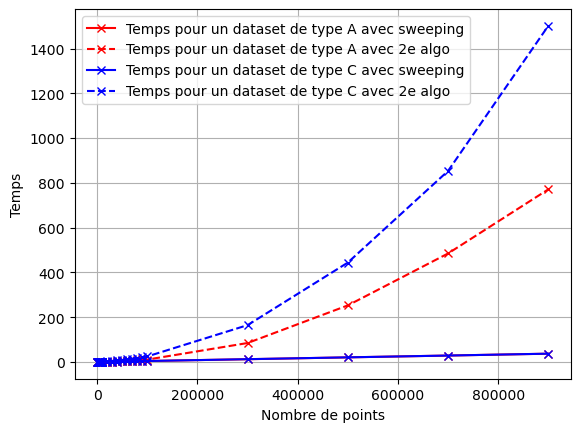

In [19]:
complexity_comparaison()